# Zadanie 1

In [1]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target

from sklearn.cluster import KMeans


Powyższe dane (dwie pierwsze zmienne Iris) podziel na 3 grup przy pomocy k-średnich. Przed użyciem KMeans() nie zapomnij o przeskalowaniu danych przy pomocy StandardScaler().
Narysuj predykcje dla meshgridu z zaznaczeniam "prawdziwej" przynależności do grup.

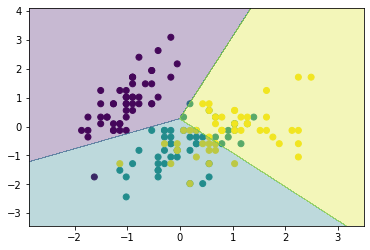

In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

kmeans = KMeans(n_clusters=3).fit(X)

x1_min, x1_max = np.min(X[:,0])-1, np.max(X[:,0])+1
x2_min, x2_max = np.min(X[:,1])-1, np.max(X[:,1])+1
xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max,1000), np.linspace(x2_min,x2_max,1000))

yy = kmeans.predict(np.c_[xx1.flatten(),xx2.flatten()]).reshape(xx1.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1], c=y)
plt.contourf(xx1,xx2,yy,alpha=.3)
plt.show()

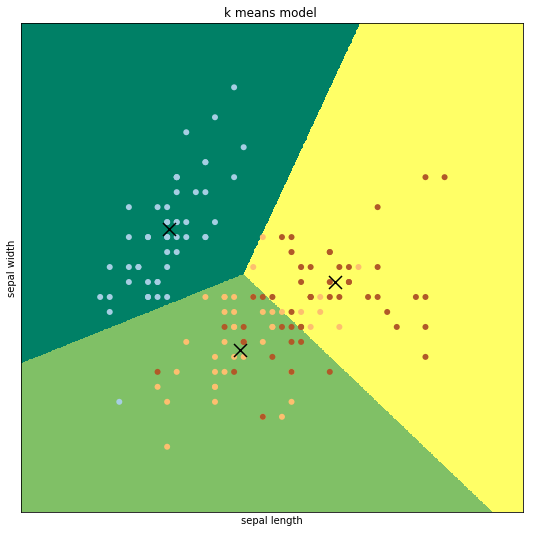

# Zadanie 2

Dane(całe) Iris podziel na 2,3,5,6,7,8,9,10 grup przy pomocy k-średnich. Który z tych podziałów jest najlepszy? 
Narysuj wykres sumy kwadratów błędów od k oraz wykres logarytmu sumy kwadratów błędów od k.

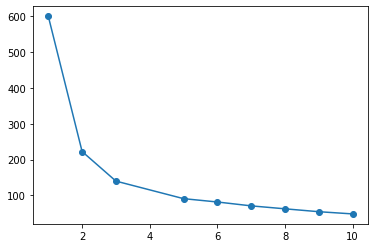

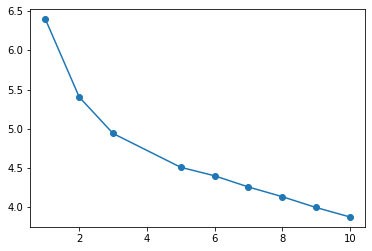

In [15]:
X = StandardScaler().fit_transform(iris.data)
y = iris.target

error = []
KK = [1,2,3,5,6,7,8,9,10]


for k in KK:
    clusters = KMeans(n_clusters=k).fit(X)
    error.append(clusters.inertia_)
    
plt.plot(KK,error,'-o')
plt.show()
plt.plot(KK,np.log(error),'-o')
plt.show()

# Zadanie 2*

Wykonaj powyższe zadanie metodą porównania ze zbiorem referencyjnym:
https://datasciencelab.wordpress.com/2014/01/21/selection-of-k-in-k-means-clustering-reloaded/


In [16]:


def alpha_K(K, X):
    N = X.shape[1]
    if K==2:
        return 1-3/(4*N)
    return alpha_K(K-1, X) + (1 - alpha_K(K-1, X))/6

def f(K, X, random_state = None):
    if K==1:
        return 1
    model = KMeans(n_clusters = K, random_state=random_state).fit(X)
    model_1 = KMeans(n_clusters = K-1, random_state=random_state).fit(X)
    S_K = model.inertia_
    S_1 = model_1.inertia_
    if S_1 == 0:
        return 1
    return S_K/(alpha_K(K,X) * S_1)

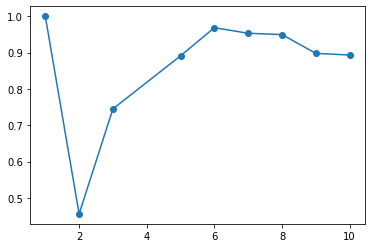

In [17]:


KK = [1,2,3,5,6,7,8,9,10]

f_vals = []

for k in KK:
    f_vals.append(f(k, X))

plt.figure()
plt.plot(KK, f_vals, '-o')
plt.show()

# Zadanie 3

Mając do dyspozycji dane Titanic, znajdź z poznanych dotąd modeli optymalny model objaśniająycy zmienną "survived". Całą pracę rozpocznij od oddzielenia losowo wybranych 20% danych. Następnie pracuj na pozostałych  80%  danych. Na końcu sprawdź działanie modelu na wcześniej oddzielonych  20%  danych.

In [22]:
#data preprocessing
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import PolynomialFeatures
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('http://stamfordresearch.com/wp-content/uploads/2016/08/Titanic.csv')
#print(df.columns)
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

#print(df.isnull().any())
mean_age = df['Age'].dropna().median()
df['Age'] = df['Age'].fillna(mean_age)
#print(df.isnull().any())

data = df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']]
data = pd.get_dummies(data)
data = data.drop(columns=['Sex_female', 'Embarked_C'])

Is_young = []
for age in df['Age']:
    if age<17:
        Is_young.append(1)
    else:
        Is_young.append(0)
        
data['Is_young'] = Is_young
X = data.to_numpy()
y = list(df['Survived'].to_numpy())

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [23]:
#logistic regression
from sklearn.linear_model import LogisticRegression
params = {'C': np.logspace(-3,3,100)}

X_train_poly = PolynomialFeatures(2).fit_transform(X_train)
X_test_poly = PolynomialFeatures(2).fit_transform(X_test)

model_prototype = GridSearchCV(LogisticRegression(max_iter=2000,tol=.2),params)
model_prototype.fit(X_train_poly,y_train)

print(model_prototype.best_params_)
C = model_prototype.best_params_['C']

model_log = LogisticRegression(C=C, max_iter=2000,tol=.2).fit(X_train_poly,y_train)
y_pred = model_log.predict(X_test_poly)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

{'C': 23.10129700083158}
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       105
           1       0.80      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

[[92 13]
 [23 51]]


In [20]:
#neural networks
from sklearn.neural_network import MLPClassifier

LAYERS = []
for knots in range(1,101):
    for layers in range(1,3):
        LAYER = []
        for i in range(layers):
            LAYER.append(knots)
        LAYERS.append(tuple(LAYER))
        
params = {'hidden_layer_sizes': LAYERS,
         'activation': ['logistic', 'tanh', 'relu']}

mlp = GridSearchCV(MLPClassifier(),params)
mlp.fit(X_train,y_train)

layer = mlp.best_params_['hidden_layer_sizes']
activ = mlp.best_params_['activation']
print(layer, activ)

(77, 77) tanh


In [21]:
model_mlp = MLPClassifier(hidden_layer_sizes=layer, activation=activ).fit(X_train,y_train)
y_pred = model_mlp.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       113
           1       0.84      0.58      0.68        66

    accuracy                           0.80       179
   macro avg       0.82      0.76      0.77       179
weighted avg       0.81      0.80      0.79       179

[[106   7]
 [ 28  38]]


In [96]:
#decision trees
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': range(10,1000,200)}
rfc = GridSearchCV(RandomForestClassifier(),params)
rfc.fit(X_train,y_train)

n_est = rfc.best_params_['n_estimators']
print(n_est)

710


In [97]:
model_rfc = RandomForestClassifier(n_estimators=n_est).fit(X_train,y_train)
y_pred = model_rfc.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       106
           1       0.79      0.67      0.73        73

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

[[93 13]
 [24 49]]
